# Apply spaTrack on spatial data of  axolotl brain regeneration after injury

## 0. Introdcution

In this tutorial section, we will illustrate the use of spaTrack for inferring cell differentiation trajectories from spatial transcriptomic data obtained during axolotl brain regeneration. Axolotls have the remarkable ability to regenerate damaged brain regions by releasing various cytokines and growth factors. The process of cell differentiation during axolotl brain regeneration has been extensively studied by Wei et al. (2022, Science), and we have obtained a similar cell differentiation trajectory using spaTrack. We will leverage this well-characterized dataset to demonstrate the approach of spaTrack for inferring cell differentiation trajectories. The spatial transcriptomic data for axolotl brain regeneration can be downloaded from [Baidu Netdisk](https://pan.baidu.com/s/1LTyUH-r3y76kztshza0HLw?pwd=3mgr) and [Google Drive](https://drive.google.com/file/d/1DHUe4WlZEIdGIH6qPlzH2NUIYeMi4FkK/view?usp=sharing).

In [1]:
import spaTrack as spt
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import warnings
warnings.filterwarnings("ignore")
sc.settings.verbosity = 0
plt.rcParams['figure.dpi'] = 200 #分辨率

/home/huangke2/huangke2_694/software/conda/envs/ST/lib/python3.8/site-packages/geopandas/_compat.py:124: UserWarning:

The Shapely GEOS version (3.11.2-CAPI-1.17.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.

/home/huangke2/huangke2_694/software/conda/envs/ST/lib/python3.8/site-packages/spaghetti/network.py:40: FutureWarning:

The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.



## 1. Prepare the Data

To use the SpaTrack, we need to ensure that our input files are in the appropriate format. We require two tsv files as input: a gene expression file and a meta file that contains cell annotation and cell coordinate information. The gene expression file should have gene names as columns and cell IDs as rows. The meta file should have four columns that include cell spatial X and Y coordinates, cell type annotation, and cell ID.

<img src="https://raw.githubusercontent.com/yzf072/spatrack/main/docs/source/_static/exp.png" width="1000px">

<img src="https://raw.githubusercontent.com/yzf072/spatrack/main/docs/source/_static/anno.png" width="1000px">

To make our data compatible with the SpaTrack example code, we should input the cell type information into 'adata.obs['cluster']', and the spatial coordinates should be placed in 'adata.obsm["X_spatial"]'. We can then convert these two tsv files into a scanpy adata object and perform standard quality control filtration and normalization steps.

In [2]:
adata = sc.read("../data/axolotl brain regeneration.ST/D15_4.ST.exp.tsv")
df_annot = pd.read_table("../data/axolotl brain regeneration.ST/D15_4.ST.annot.tsv")
# adata=sc.read('/home/huangke2/huangke2_694/27.spatial.trajectory/12.SpaTrack/02.axolotl/D15_4/D15_4.ST.exp.tsv')
# df_annot = pd.read_table("/home/huangke2/huangke2_694/27.spatial.trajectory/12.SpaTrack/02.axolotl/D15_4/D15_4.ST.annot.tsv")
adata.obs["cluster"] = df_annot["cluster"].values
adata.obsm["X_spatial"] = df_annot[["x", "y"]].values
adata.layers["counts"] = adata.X

In [3]:
sc.pp.filter_genes(adata, min_cells=10)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)

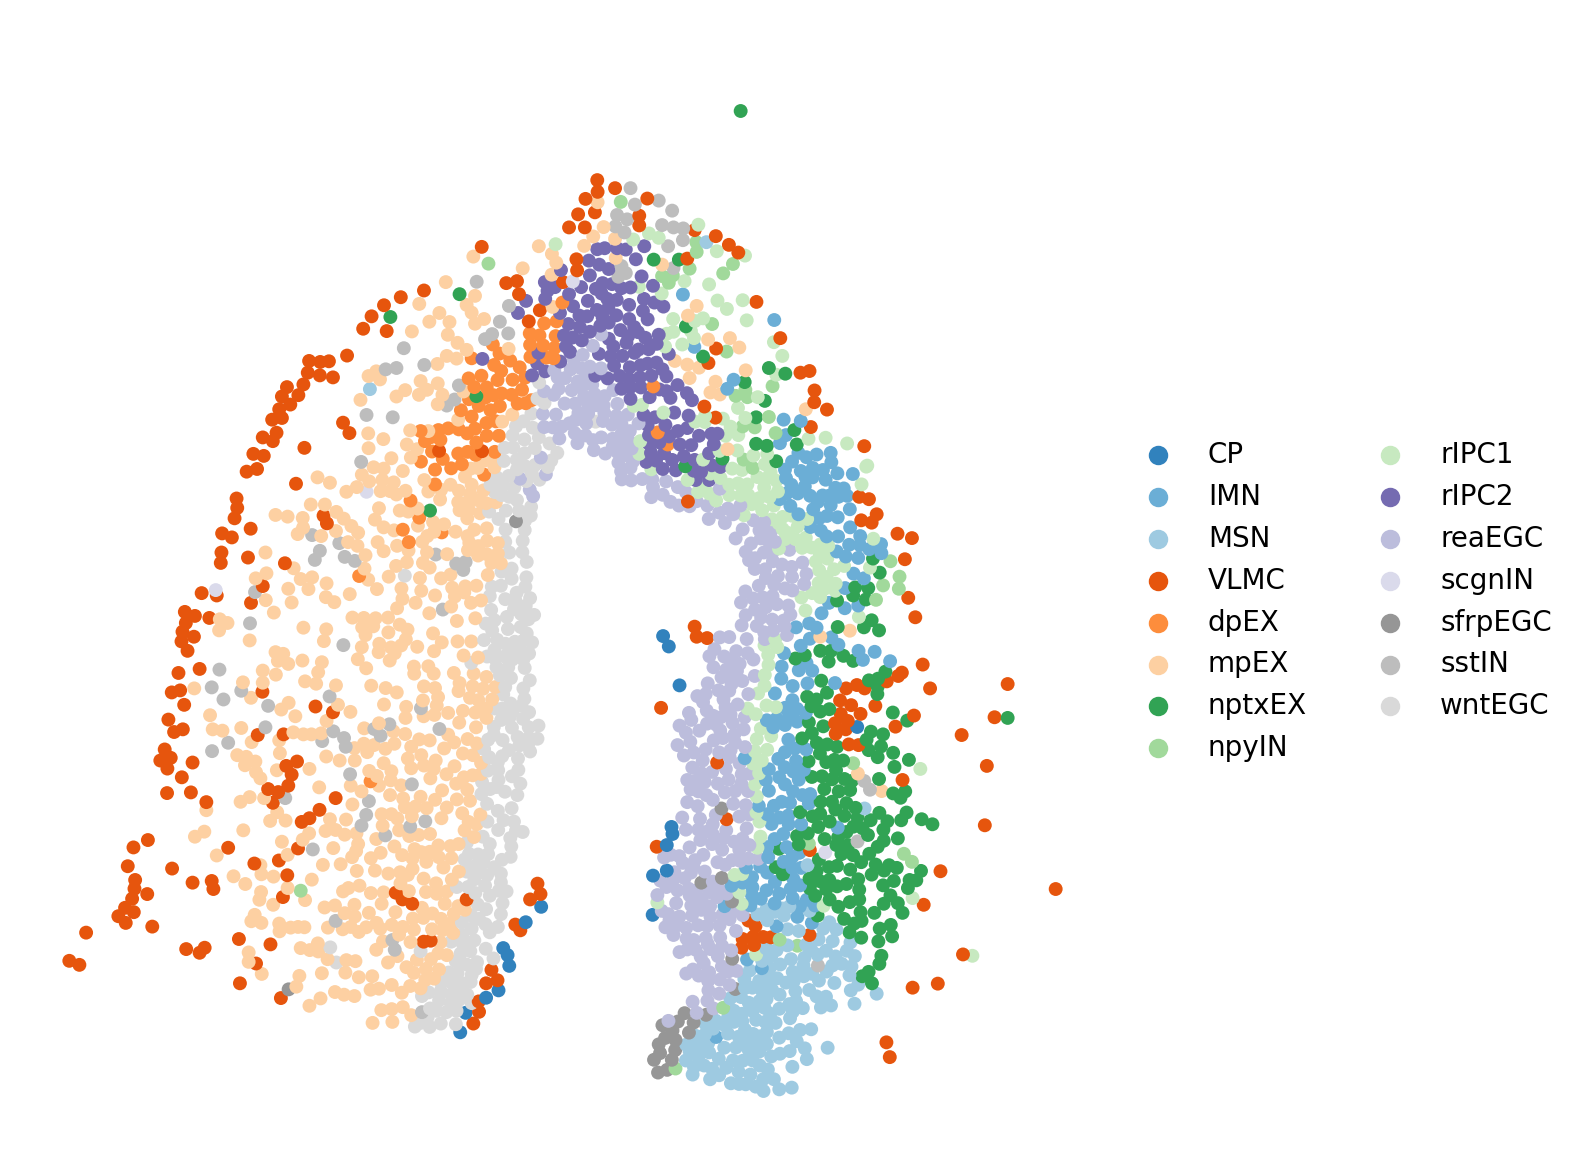

In [4]:
fig, axs = plt.subplots(figsize=(7, 7))
ax = sc.pl.embedding(adata, basis='X_spatial', show=False, 
    color='cluster', ax=axs, frameon=False, title=' ', palette='tab20c', size=100
                    )


readEGC： reactive ependymoglial cells;  rIPC：regeneration intermediate progenitor cells;  
IMN：immature neuron;  nptxEX: Nptx+ lateral pallium excitatory neurons;  
MSN：medium spiny  neuron;  sfrpEGC：sfrp+ ependymoglial cells;  
CP：choroid plexus;  VLMC：vascular leptomeningeal cell;  wntEGC：
Wnt+ EGC;  mpEX：medial pallium excitatory neuron;  sstIN：Sst+ inhibitory neuron;  
scgnIN:Scgn+ inhibitory neuron;  dpEX：dorsal palliumexcitatory neuron;



## 2. Choose start cells

Before inferring a cell differentiation trajectory using spaTrack, we need to select a starting cluster or specify a group of cells as the beginning of the trajectory. This step is crucial in ensuring the reliability of the inferred trajectory.

In spaTrack, we provide two methods to determine the starting cluster including automatically and manually slecte starting cluster. We recommend that users manually slecte starting cluster base on prior knowledge and biological evidence.

One way to select a starting cluster is to identify a cluster that has a higher G2M score and a higher stem cell differentitation score. 

Alternatively, users can manually select a starting point by specifying spatial coordinates or by using the lasso function to circle cells of interest.

For our analysis of axolotl brain regeneration data, we manually selected reaEGC (reactive EGC) cells as the starting cells since they cover the injury site and have higher G2M scores as well as stem cell differentitation signaling. 

To facilitate the identification of specific interesting regions, we provide an interactive function that allows users to circle the region of interest and obtain the corresponding cell coordinates.

### 2.1 Method 1: automatically determining the starting cluster

Assese G2M score and stem cell differentitation signaling in each cluster to identify the starting cluster. Higher G2M  and stem cell differentitation score indicate more likely to be starting cluster.

The spt.assess_start_cluster() function outputs the G2M score and stem cell differentiation score for each cluster.

The spt.assess_start_cluster_plot() function displays boxplot of the sorted G2M score and stem cell differentiation score for each cluster.

readEGC has the highest G2M and stem cell differentiation scores, it is more likely to be the starting cluster.

In [5]:
adata=spt.assess_start_cluster(adata)

Cluster order sorted by G2M score:  ['reaEGC', 'wntEGC', 'CP', 'sfrpEGC', 'rIPC1', 'scgnIN', 'VLMC', 'nptxEX', 'IMN', 'mpEX', 'rIPC2', 'sstIN', 'npyIN', 'MSN', 'dpEX']


G2M_score
reaEGC    0.045919
wntEGC    0.027234
CP        0.006995
sfrpEGC  -0.013089
rIPC1    -0.020052
scgnIN   -0.032515
VLMC     -0.038728
nptxEX   -0.039925
IMN      -0.042423
mpEX     -0.046572
rIPC2    -0.046923
sstIN    -0.048125
npyIN    -0.053156
MSN      -0.053304
dpEX     -0.058503

Cluster order sorted by Stem Cell Differentiation score:  ['reaEGC', 'sfrpEGC', 'wntEGC', 'rIPC2', 'IMN', 'rIPC1', 'MSN', 'npyIN', 'dpEX', 'CP', 'nptxEX', 'sstIN', 'mpEX', 'scgnIN', 'VLMC']


Mean of Stem Cell Differentiation score  cell_number
reaEGC                                  0.311365          333
sfrpEGC                                 0.305774           24
wntEGC                                  0.299841          232
rIPC2                                   0.273654          136
IMN                                     0.258296          167
rIPC1                                   0.253858          152
MSN                                     0.250082          154
npyIN                                   0.248576           36
dpEX                                    0.239419           76
CP                                      0.236842           19
nptxEX                                  0.235385          180
sstIN                                   0.230287           83
mpEX                                    0.225793          558
scgnIN                                  0.196874            4
VLMC                                    0.189236          242

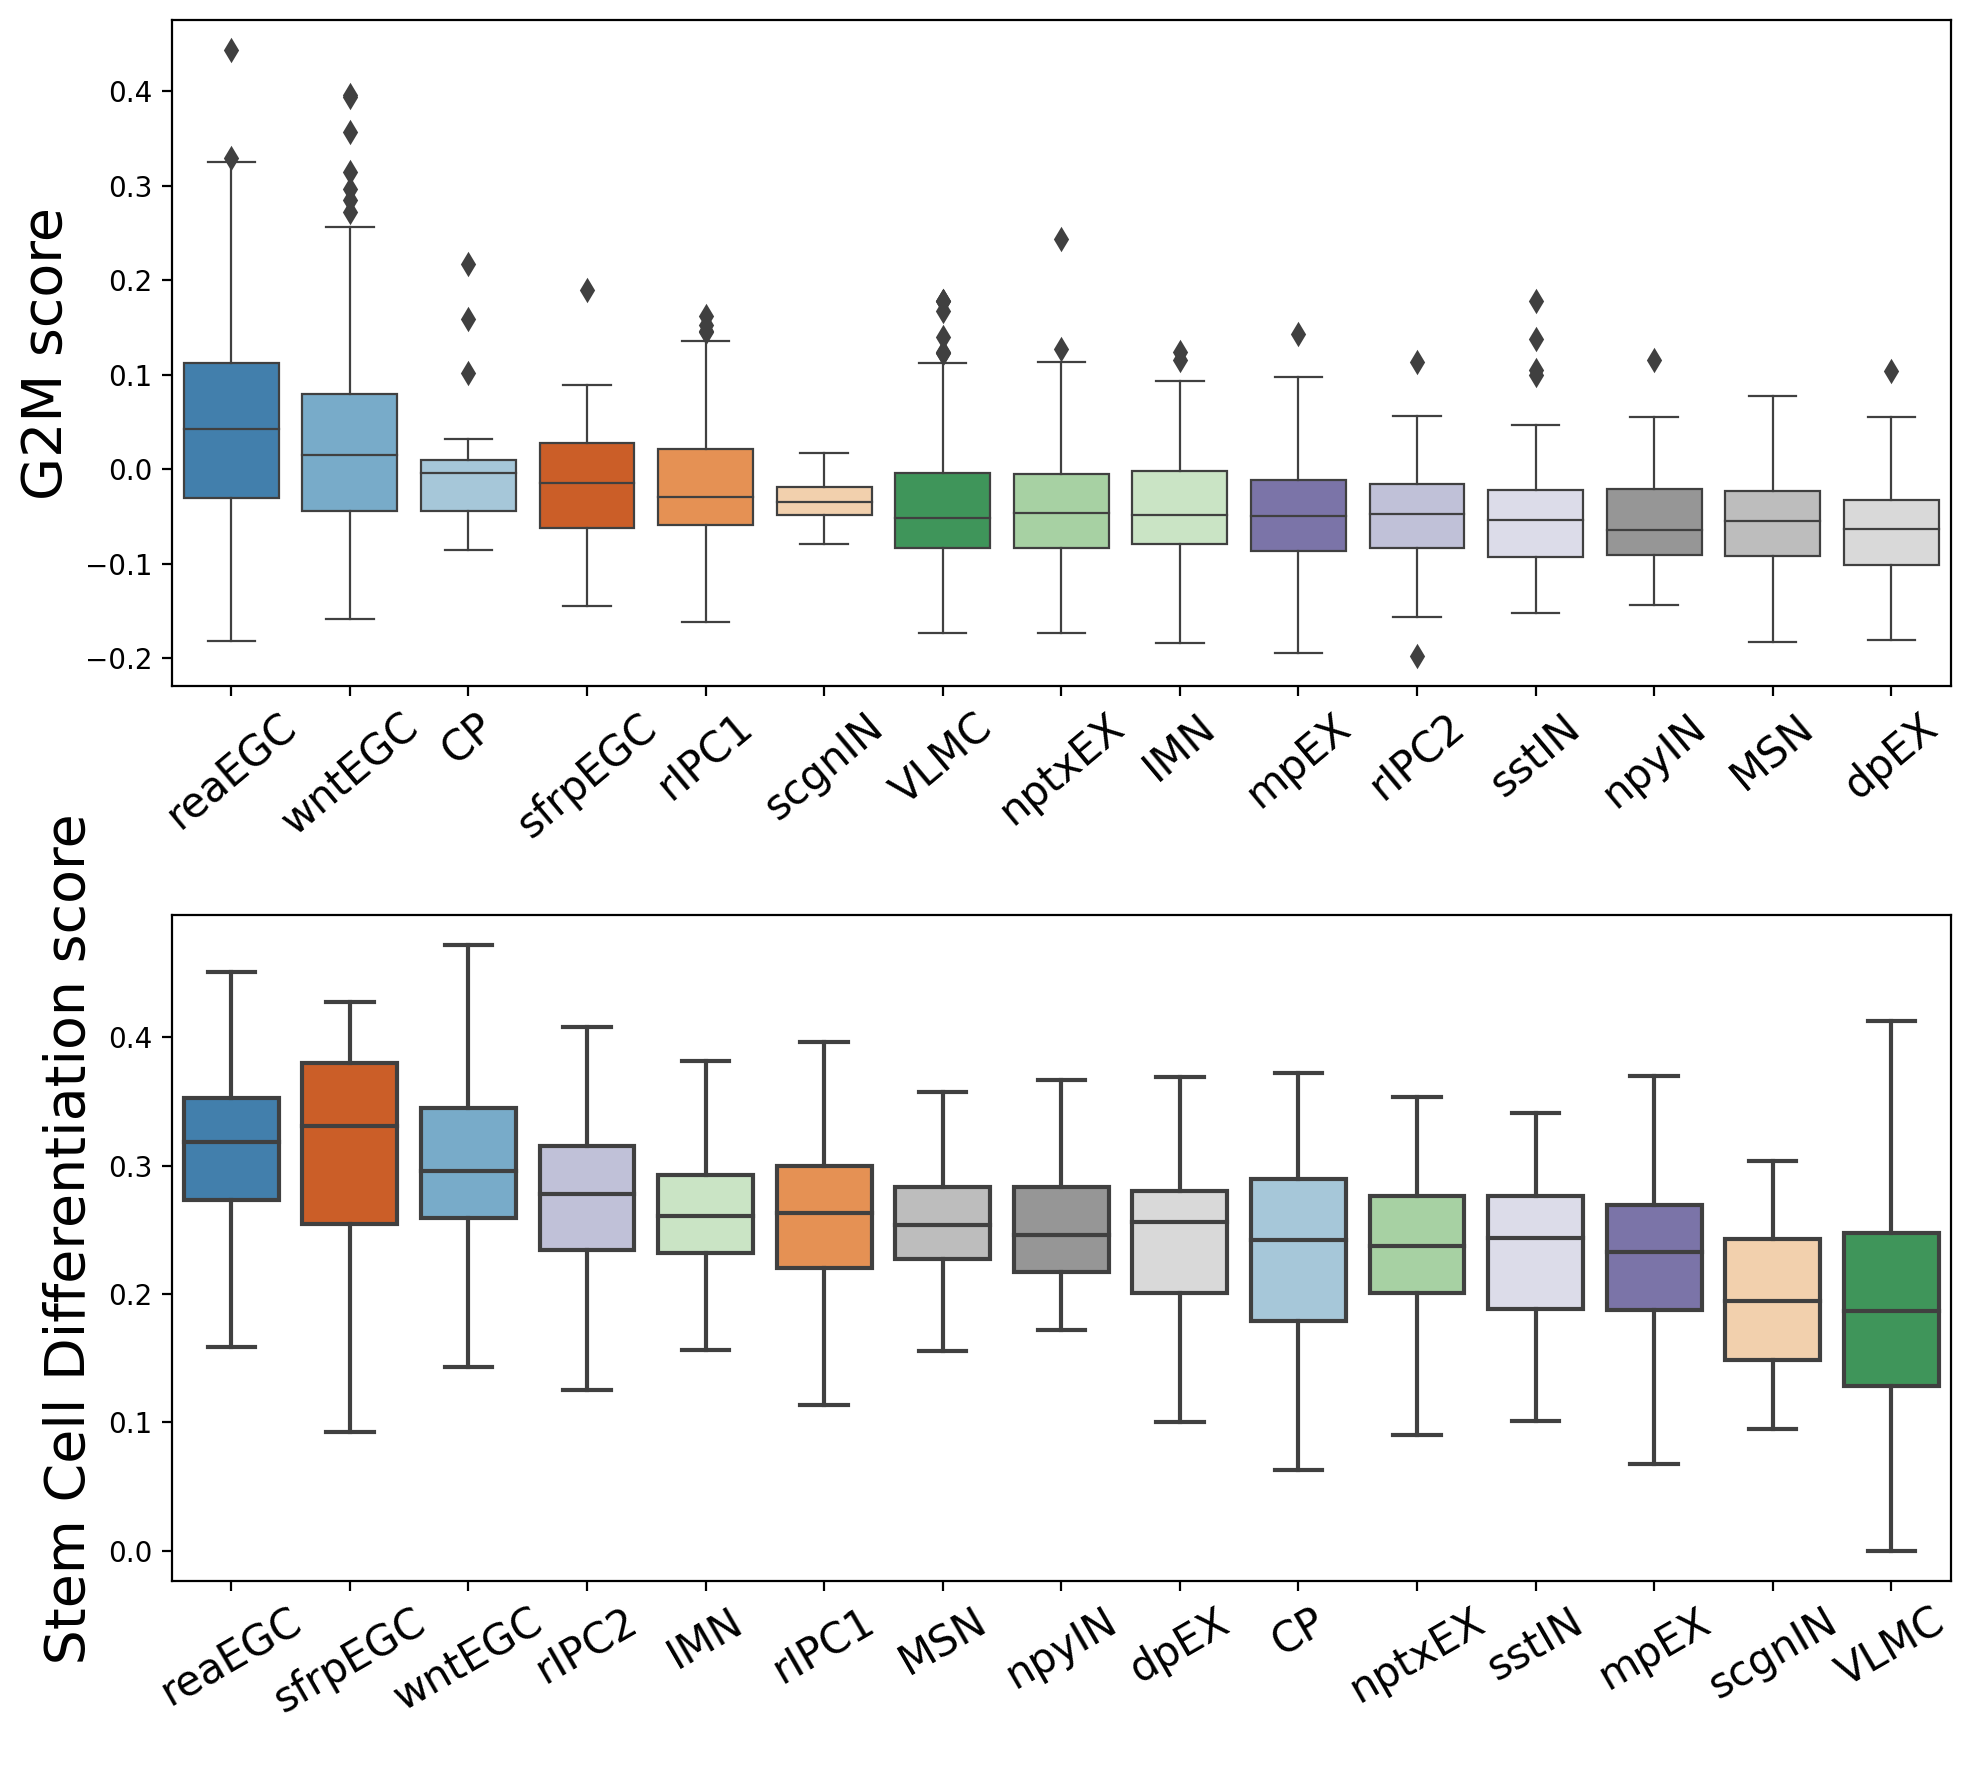

In [6]:
spt.assess_start_cluster_plot(adata)

### 2.2 Method 2: Manually select start cells

It is recommended that users manually select the starting cluster based on prior knowledge and biological evidence. In the absence of such knowledge, users can refer to the above result, which was automatically determined starting cluster

#### 2.2.1 Select start cells by coordinates

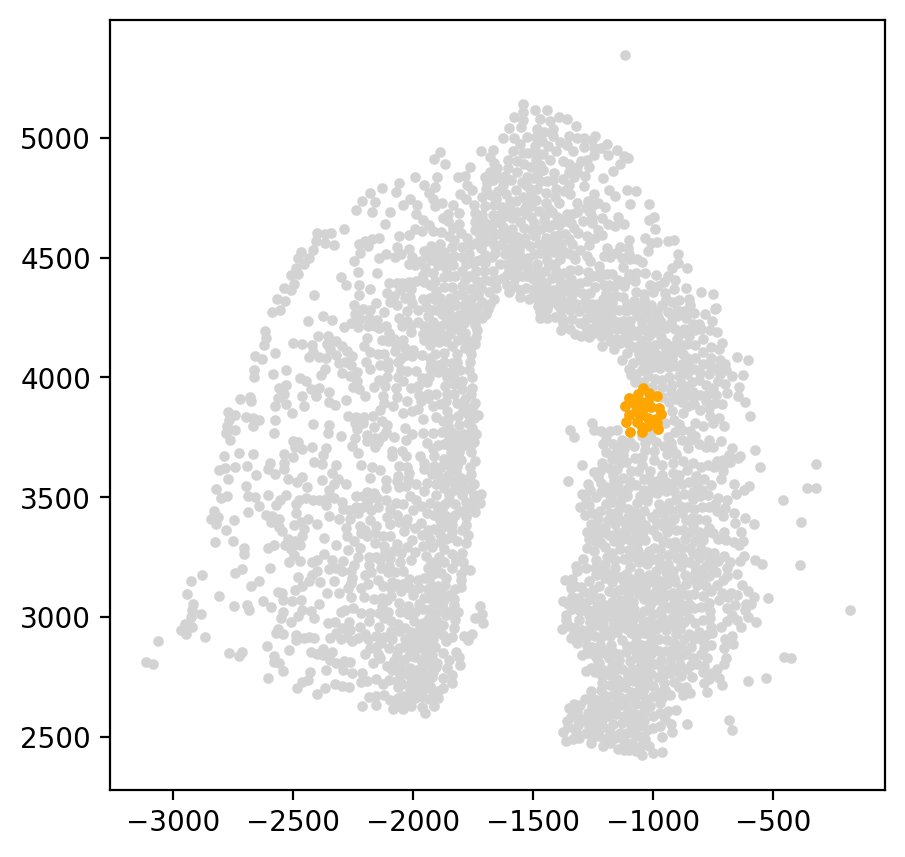

In [7]:
start_cells = spt.set_start_cells(adata, select_way='coordinates', cell_type='reaEGC', start_point=[-1050,3850], n_neigh=30)

fig, axs = plt.subplots(figsize=(5,5))
plt.scatter(adata.obsm['X_spatial'][:,0], adata.obsm['X_spatial'][:,1], c='#D3D3D3', s=8)
plt.scatter(adata.obsm['X_spatial'][start_cells][:,0], adata.obsm['X_spatial'][start_cells][:,1], c='orange', s=8)

#### 2.2.2 Select start cells by cell type

In [8]:
# start_cells=spt.set_start_cells(adata,select_way='cell_type',cell_type='reaEGC')

# fig, axs = plt.subplots(figsize=(5,5))
# plt.scatter(adata.obsm['X_spatial'][:,0],adata.obsm['X_spatial'][:,1],c='#D3D3D3',s=8)
# plt.scatter(adata.obsm['X_spatial'][start_cells][:,0],adata.obsm['X_spatial'][start_cells][:,1],c='orange',s=8)

#### 2.2.3 Select start cells by lasso

In [9]:
# L=spt.Lasso(adata)
# L.vi_plot(basis='X_spatial',cell_type='reaEGC')

<iframe src="../_static/lasso.html" width="100%" height="500"></iframe>

In [10]:
# start_cells=L.sub_cells
# fig, axs = plt.subplots(figsize=(5, 5))
# plt.scatter(adata.obsm['X_spatial'][:,0],adata.obsm['X_spatial'][:,1],c='#D3D3D3',s=8)
# plt.scatter(adata.obsm['X_spatial'][start_cells][:,0],adata.obsm['X_spatial'][start_cells][:,1],c='orange',s=8)

## 3. Calculate cell transition probability

To calculate the trajectory velocity from spatial transcriptomics data using spaTrack, we first input the gene expression matrix (N x M, where N is the number of cells and M is the number of genes) and use optimal transport theory to calculate the cell transition probability matrix (N x N).

In the case of axolotl brain regeneration spatial transcriptomics data, we set the data type as 'spatial' to incorporate the cell spatial position information and obtain more accurate cell transition probability values.

The default parameters for alpha1 and alpha2 in spt.get_ot_matrix() are set to equal with 0.5 and 0.5, assuming that gene expression and spatial distance are independent. We provide a method using moran'I to estimate alpah1 and alpah2 as a reference from input ST data .
<!--    Infer trajectory velocity and
cell transition probability matrix -->

In [12]:
alpha1, alpha2=spt.auto_estimate_para(adata,hvg_gene_number=2000)

Parameter estimation of alpah1 for gene expression is: 0.592
Parameter estimation of alpah2 for distance is: 0.408


In [14]:
#adata.obsp["trans"] = spt.get_ot_matrix(adata, data_type="spatial",alpha1=0.5,alpha2=0.5)
adata.obsp["trans"] = spt.get_ot_matrix(adata, data_type="spatial",alpha1=0.592,alpha2=0.408)

alpha1(spatial information): 0.592   alpha2(gene expression): 0.408


## 4. Caculate cell pseudotime

After calculating the cell transition probability matrix, we calculate the sum of probabilities of all initial cells transferring to each cell. Next, we sort all the cells based on the sum of transition probabilities from largest to smallest.

To assign a value between 0-1 as ptime for each cell, we use an arithmetic sequence. The cell with the largest sum of transition probabilities is assigned a ptime value of 0, while the cell with the smallest sum is assigned a ptime value of 1. The cells in between are assigned ptime values based on their sort order.

In [15]:
adata.obs["ptime"] = spt.get_ptime(adata, start_cells)

## 5. Calculate vector field velocity.

After assigning ptime values to each cell, we need to determine the cell neighbors, which is an important factor for cell velocity. The cell neighbors can be determined based on the cell spatial coordinates, corresponding to the parameters 'n_neigh_pos'. For spatial data, we use 'X_spatial' coordinates. 'UMAP' is used for scRNA data. We use the intersection of the spatial coordinate neighbors and embedding matrix neighbors to determine the cell neighbors.

For each cell, we take the direction from the cell point to the neighbor as the vector field speed direction. If the neighbor cell's pseudotime value is larger than the cell, we reverse the speed direction. After determining the vector field speed direction, we use the cell transition probability of the cell to its neighbors as the conjunctive speed in the vector field. The final velocity of the cell depends on the average conjunctive speed value to its neighboring cells.

To present the cell velocity in a streamline plot, we divide the two-dimensional planes into 50x50 grids and convert the cell velocity into grid velocity. We then select the average speed of the neighboring cells near the grid point as the speed of the grid point. The distance from the cell to the grid point determines the weight of the cell speed, with cells closer to the grid point having a larger weight.

In [16]:
adata.uns["E_grid"], adata.uns["V_grid"] = spt.get_velocity(adata, basis="spatial", n_neigh_pos=50)

The velocity of cells store in 'velocity_spatial'.


## 6.Plot results

Here, the information of start cells, cell pseudotime and cell velocity results have been stored into adata. Users can visualize focused information from the adata. We display pseudotime value distribution, cell quiver plot and cell trajectory plot in the following.

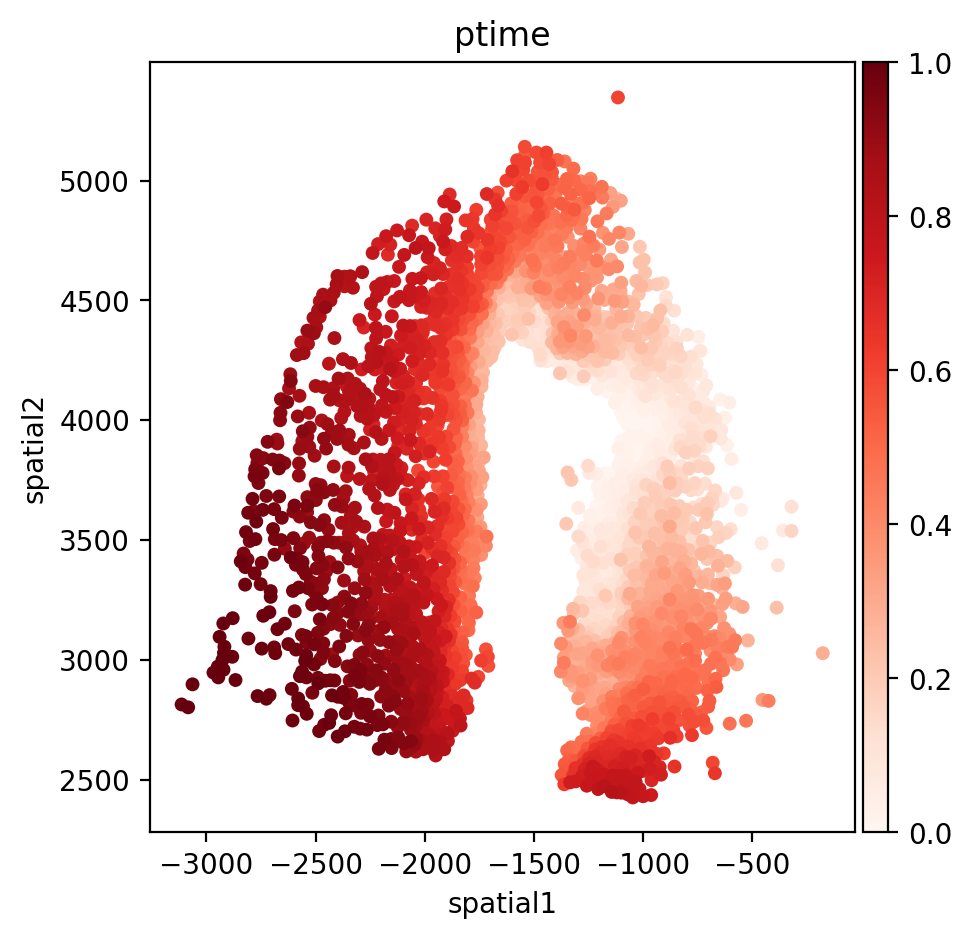

In [17]:
fig, axs = plt.subplots(figsize=(5, 5))
sc.pl.embedding(adata, basis='spatial', color='ptime', show=False, ax=axs, color_map='Reds', title='ptime', size=100)
axs.xaxis.set_major_locator(ticker.MultipleLocator(500))
axs.yaxis.set_major_locator(ticker.MultipleLocator(500))


In the quiver plot, the length of the arrow can be adjusted by adjusting the scale attribute. The smaller the scale, the longer the arrow.

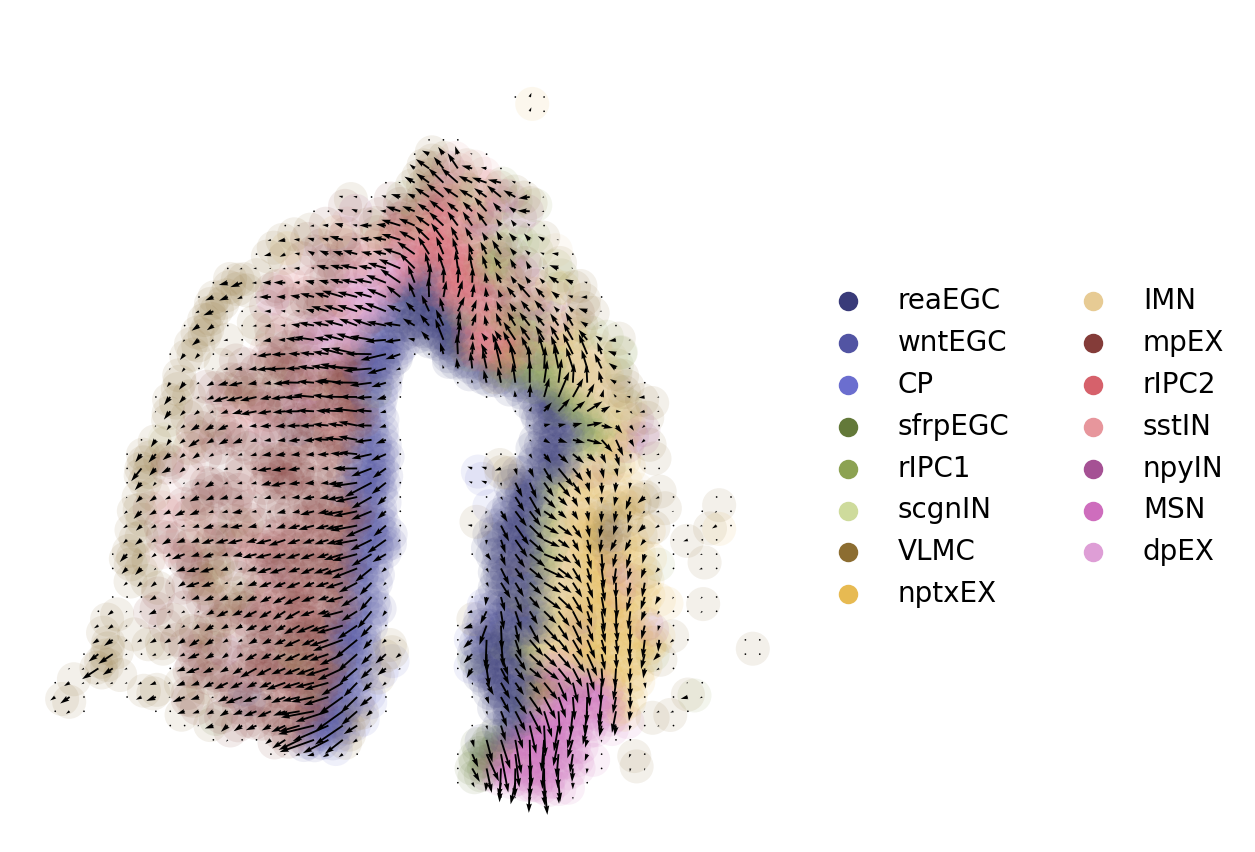

In [18]:
fig, axs = plt.subplots(figsize=(5, 5))
sc.pl.embedding(adata, basis='spatial',show=False,title=' ',color='cluster',ax=axs,frameon=False,palette='tab20b',legend_fontweight='normal',alpha=0.1,size=600)
axs.quiver(adata.uns['E_grid'][0],adata.uns['E_grid'][1],adata.uns['V_grid'][0],adata.uns['V_grid'][1],scale=0.008)
#plt.savefig("230719_axolotl_quiver.pdf", format='pdf',bbox_inches='tight')

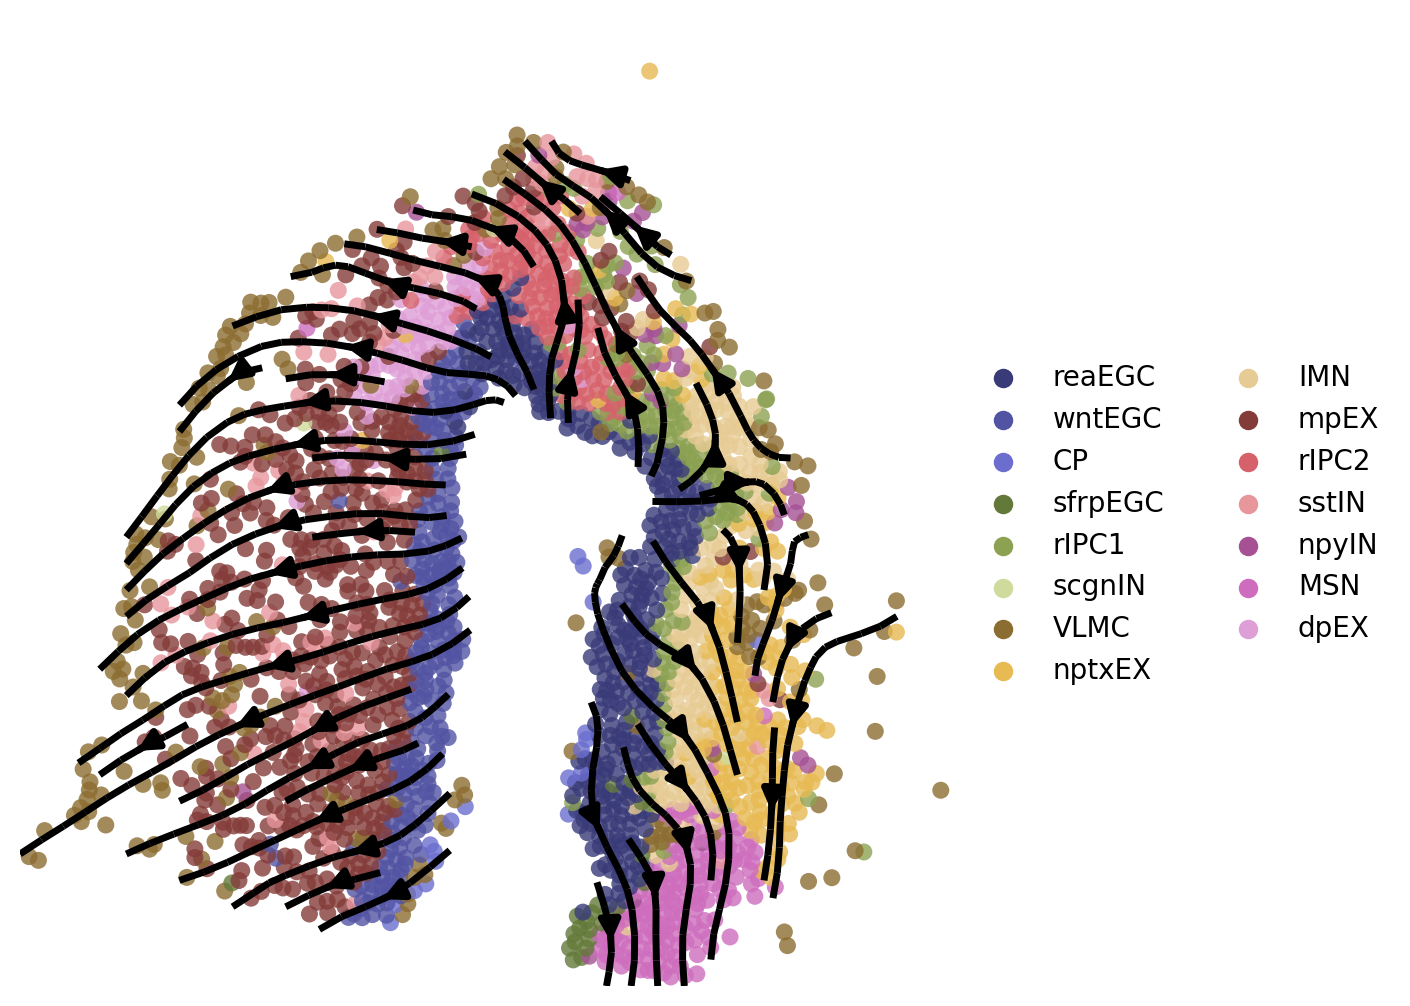

In [19]:
fig,axs=plt.subplots(ncols=1,nrows=1,figsize=(6,6))
ax = sc.pl.embedding(adata,  basis='spatial',show=False,title=' ',color='cluster',ax=axs,frameon=False,palette='tab20b',legend_fontweight='normal',alpha=0.8,size=150)
ax.streamplot(adata.uns['E_grid'][0], adata.uns['E_grid'][1], adata.uns['V_grid'][0], adata.uns['V_grid'][1],density=1.2,color='black',linewidth=2.5,arrowsize=1.5)

## 7. Downstream analysis

After inferring the cell differentiation trajectory, we can focus on a group of cell types that undergo a branching in the trajectory, which may play a critical role in brain regeneration after injury. To predict the optimal transition path of cell fate transition, we use the least action path (LAP) algorithm, which identifies the most probable path for cells to transition between different cell states while minimizing the overall energy required for the transition. By using the LAP algorithm, we can identify key driver genes of cell-fate transitions in the trajectory branching.

### 7.1 Least Action Path (LAP)

To effectively apply the least action path (LAP) method to spatial transcriptomics data, we have refined the algorithm by reconstructing the vector field at the cell level. This allows us to find the trajectory that best fits the vector field and eliminate any potential interference caused by weakly correlated cells in the trajectory. The LAP algorithm relies on the velocity of each cell to infer the optimal transition path, hence the need to reconstruct the grid-level vector field into a cell-level format.

In [20]:
VecFld=spt.VectorField(adata,basis='spatial')

To infer the least action path (LAP) of the trajectory, users need to specify a starting and an ending cell. LAP algorithm utilizes the velocity of each cell to infer the optimal transition path between the two specified cells. It searches for the path that minimizes the action integral, which is a measure of the total kinetic energy along the path. This optimal path reflects the most likely transition of cells between the two specified cells based on their velocity field.

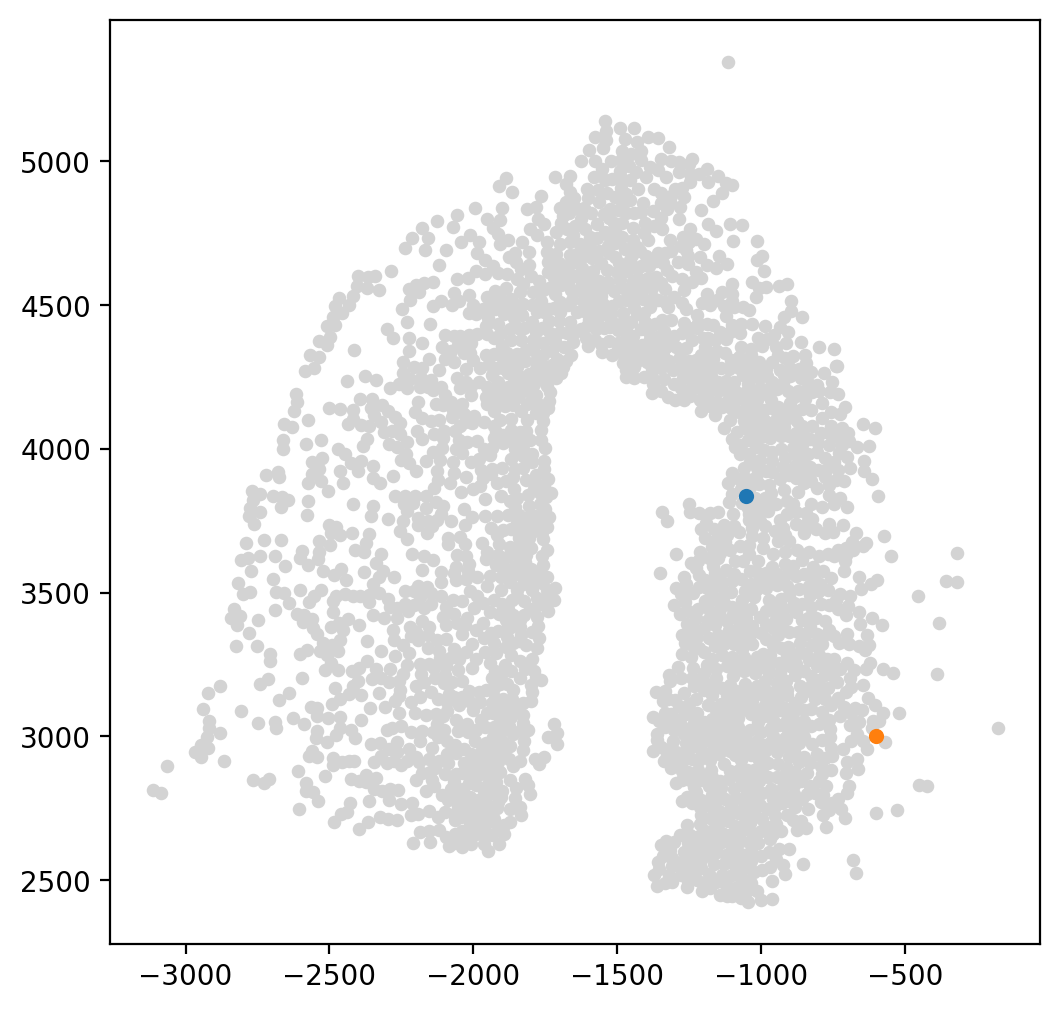

In [21]:
fig, ax = plt.subplots(figsize=(6, 6))

LAP_start_point=[-1050,3850]
LAP_end_point=[-625,3000]
LAP_start_cell=spt.nearest_neighbors(LAP_start_point,adata.obsm['X_spatial'])[0][0]
LAP_end_cell=spt.nearest_neighbors(LAP_end_point,adata.obsm['X_spatial'])[0][0]

plt.scatter(*adata.obsm["X_spatial"].T,c='#D3D3D3',s=15)
plt.scatter(*adata[LAP_start_cell].obsm['X_spatial'].T,s=20)
plt.scatter(*adata[LAP_end_cell].obsm['X_spatial'].T,s=20)

LAP is a method that can determine the optimal path between a given starting point (LAP_start_point) and end point (LAP_end_point) based on cell velocity. It does so by utilizing an Expectation-Maximization algorithm to search for the path with the lowest action, and iteratively updating the optimal path until convergence. Users can adjust the number of steps taken by the algorithm to obtain a more smooth and optimal path, known as the Least Action Path.

In [22]:
lap=spt.least_action(adata,
    init_cells=adata.obs_names[LAP_start_cell],
    target_cells=adata.obs_names[LAP_end_cell],
    vecfld=VecFld,
    basis='spatial',
    adj_key='X_spatial_distances',
    EM_steps=5,
    n_points=20
)

After selecting cells along the focused trajectory branching using the LAP, we assign a new pseudotime value to each of these cells based on their position along the LAP. We then plot the LAP to visualize the optimal transition path of the focused trajectory branching. This can provide insights into the progression of cell fate transitions and potential key driver genes along this trajectory.

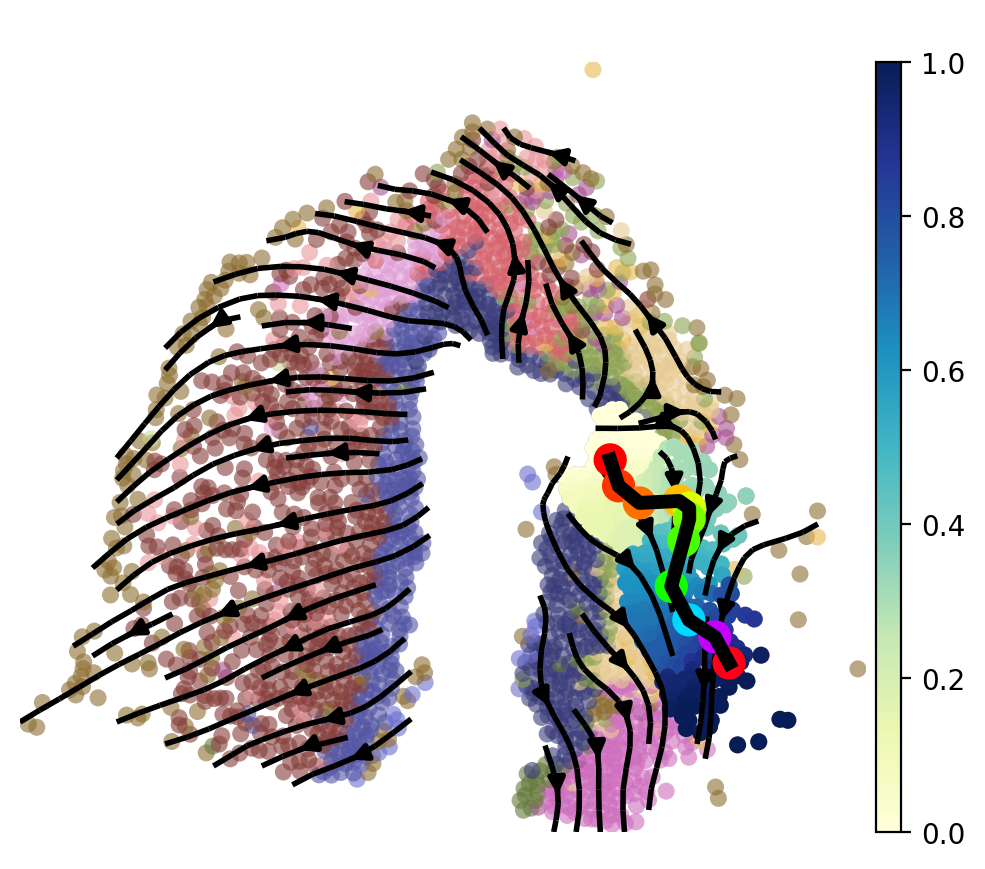

In [23]:
LAP_ptime,LAP_nbrs=spt.map_cell_to_LAP(adata,cell_neighbors=80)
sub_adata=adata[LAP_nbrs,:]
sub_adata.obs['ptime']=LAP_ptime
sub_adata=sub_adata[np.argsort(sub_adata.obs["ptime"].values), :].copy()

fig, ax = plt.subplots(figsize=(6,5))
plt.axis('off')
ax = sc.pl.embedding(adata,  basis='X_spatial',color='cluster',show=False,ax=ax,frameon=False,legend_loc=None,alpha=0.6,size=150)
ax.streamplot(adata.uns['E_grid'][0], adata.uns['E_grid'][1], adata.uns['V_grid'][0], adata.uns['V_grid'][1],density=1.2,color='black',linewidth=2,arrowsize=1.2)
ax = spt.plot_least_action_path(adata,basis='spatial',ax=ax,point_size=120,linewidth=5)
sc.pl.embedding(sub_adata, basis='X_spatial',ax=ax, color="ptime", cmap="YlGnBu",frameon=True,size=150,title=' ')

###  7.2 pseudotime-dependent genes on LAP

To identify genes that drive cell transition along the optimal transition path, we fit gene expression values and cell pseudotime values using the Generalized Additive Model (GAM). This allows us to identify genes that are significantly associated with pseudotime values,and are therefore considered pseudotime-dependent genes.

First,we choose focused cell type on optimal transition path and filter genes with high variability and expression levels greater than a minimum expression proportion.

In [24]:
sub_adata_path=sub_adata[sub_adata.obs['cluster'].isin(['reaEGC','rIPC1', 'IMN','nptxEX'])]
sub_adata_path=spt.filter_gene(sub_adata_path,min_exp_prop=0.1,hvg_gene=3000)

clusters ordered by ptime:  ['reaEGC', 'rIPC1', 'IMN', 'nptxEX']
Cell number	282
Gene number	1115


Then, we fit gene expression and corresponding cell pseudotime using Generalized Additive Model.

To filter pseudotime-dependent genes, we evaluated the quality of the model fit by calculating the R2 value. We also controlled for false discovery rate (FDR) using multiple testing correction. Genes with a high R2 value and a low FDR were considered as pseudotime-dependent genes, which may be important in driving cell-fate transitions along the optimal transition path.

In [25]:
df_res  = spt.ptime_gene_GAM(sub_adata_path,core_number=5)

Genes number fitted by GAM model:   1115


In [26]:
df_sig_res = df_res.loc[(df_res['model_fit']>0.2) & (df_res['fdr']<0.05)]

Finally selected 50 genes.


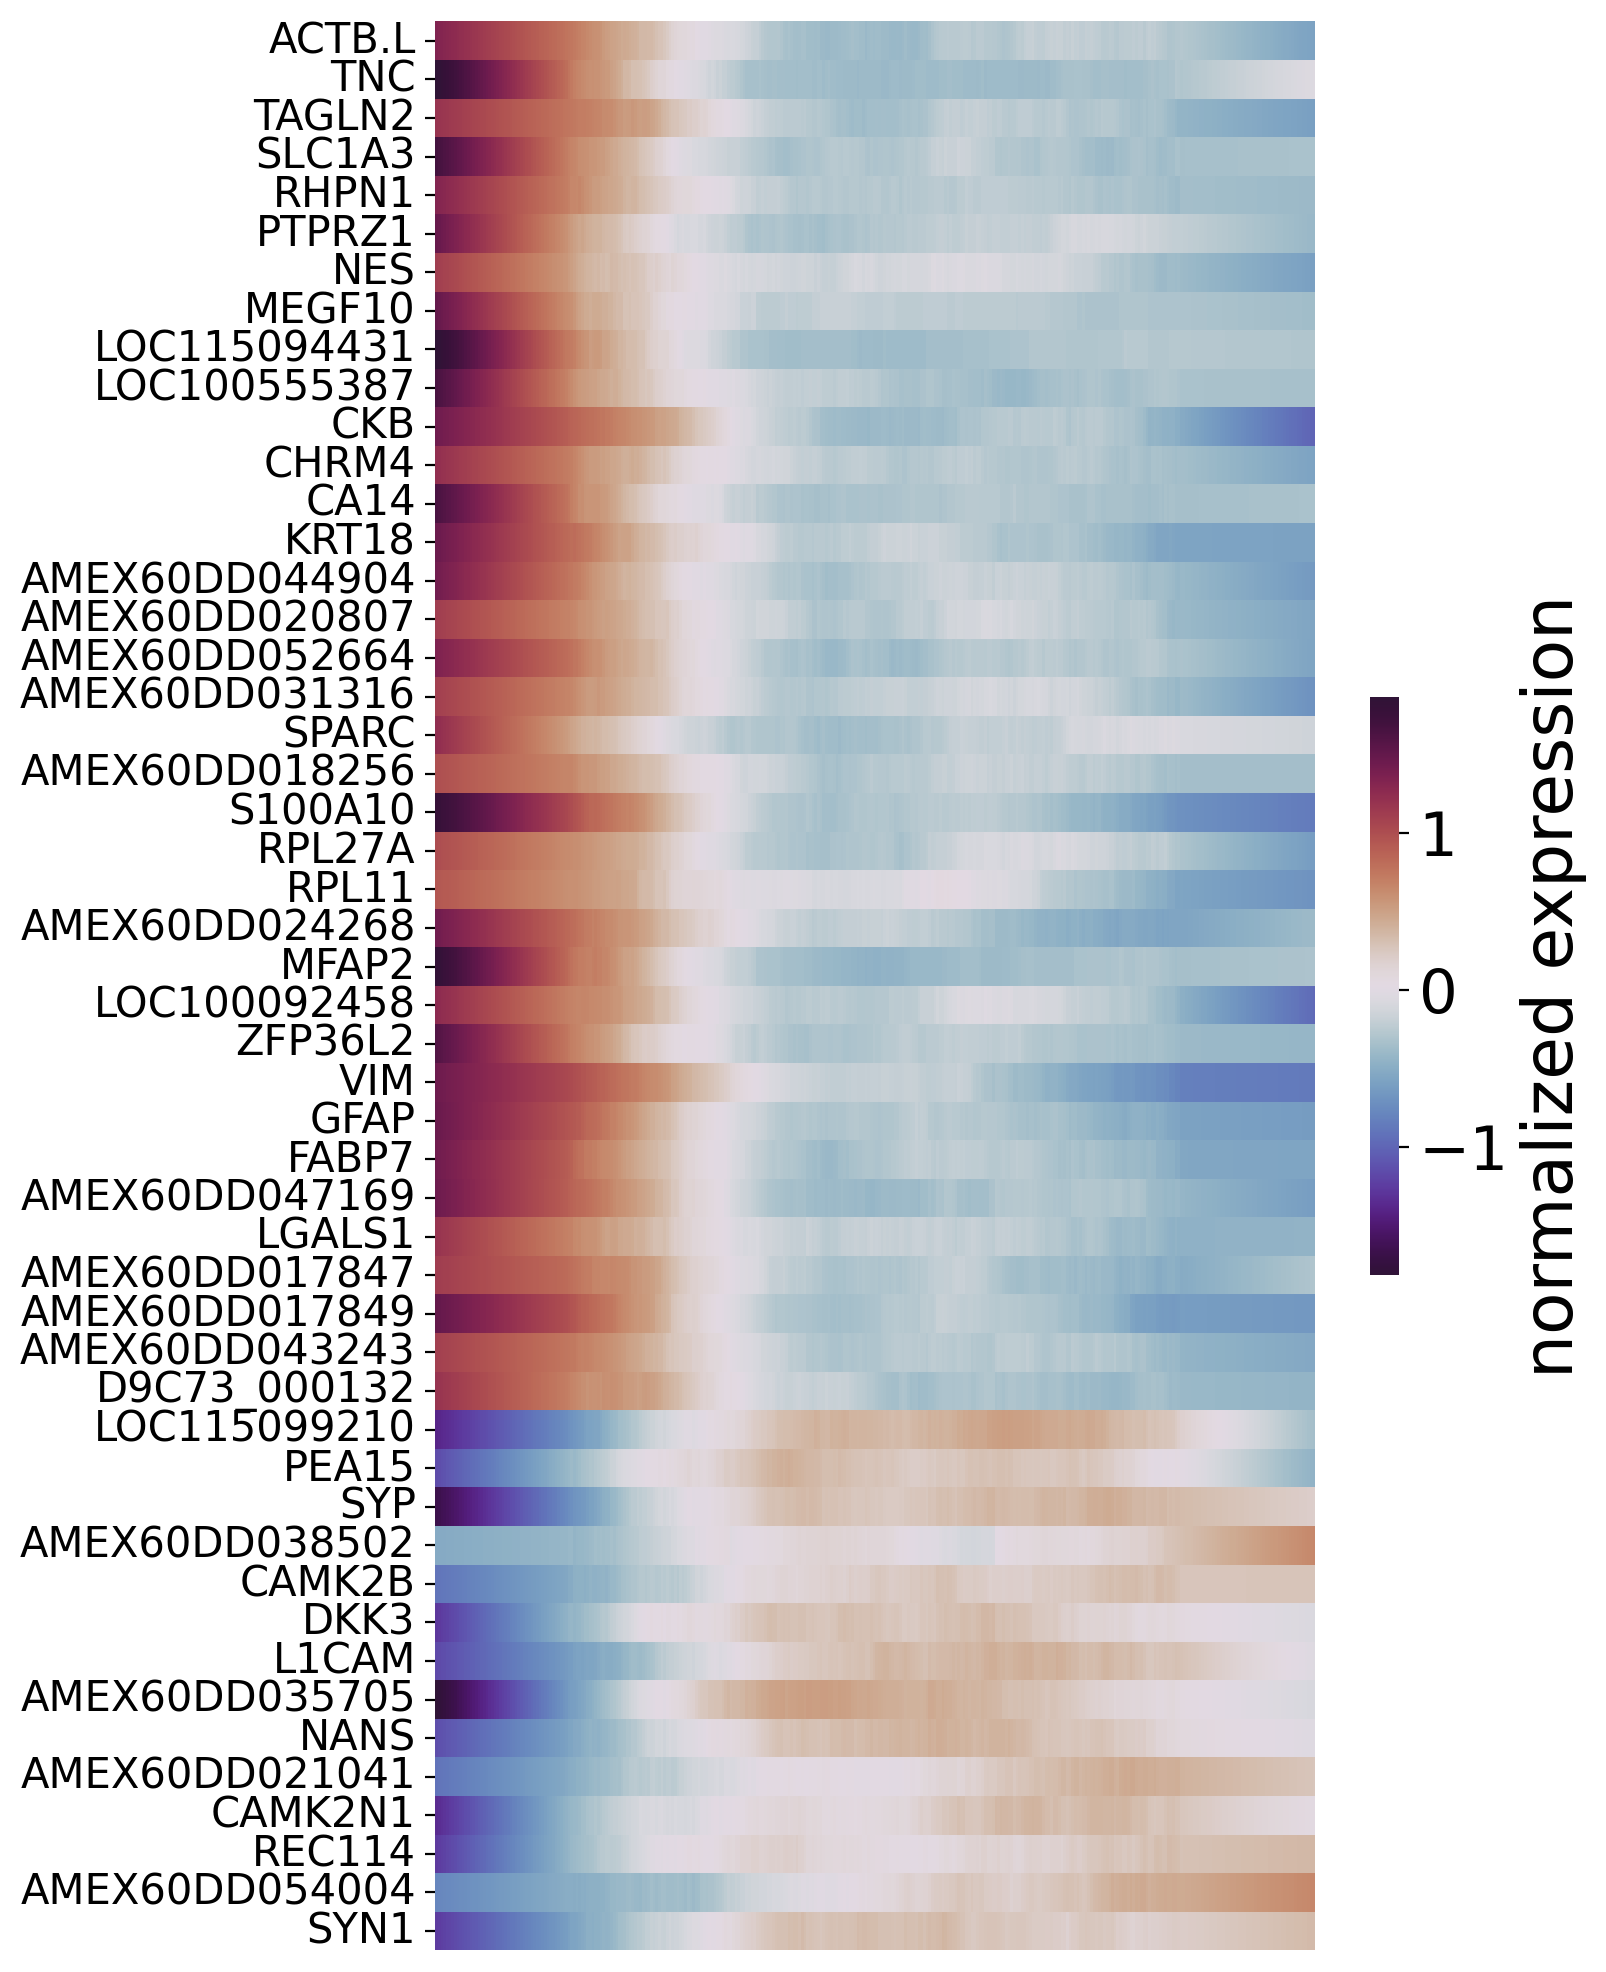

In [27]:
sort_exp_sig = spt.order_trajectory_genes(sub_adata,df_sig_res,cell_number=20)
spt.plot_trajectory_gene_heatmap(sort_exp_sig,smooth_length=100,gene_label_size=15,cmap_name='twilight_shifted')

Displayg the expression of a single key gene along ptimes.

<Axes: title={'center': 'VIM'}, xlabel='ptime', ylabel='expression'>

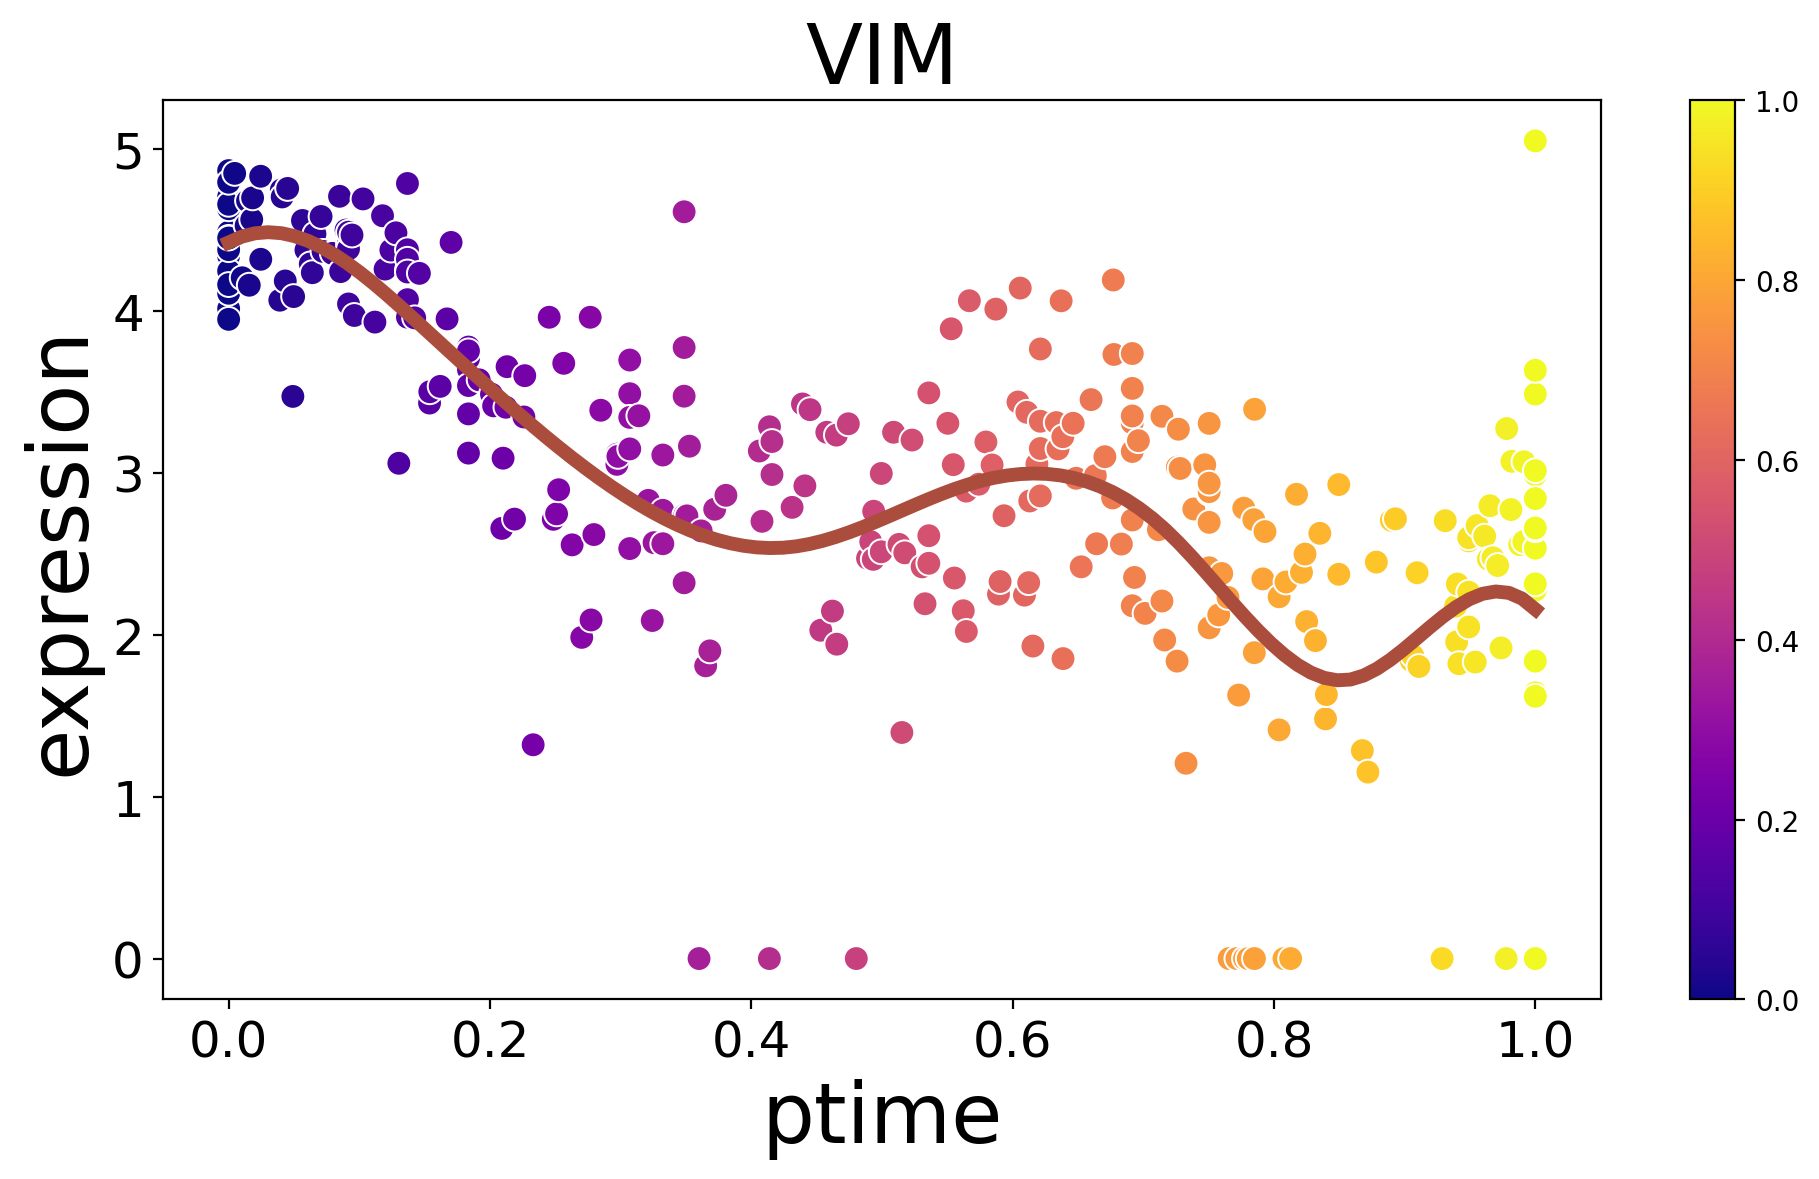

In [30]:
spt.plot_trajectory_gene(sub_adata,gene_name='VIM',point_size=80)

<Axes: title={'center': 'SYP'}, xlabel='ptime', ylabel='expression'>

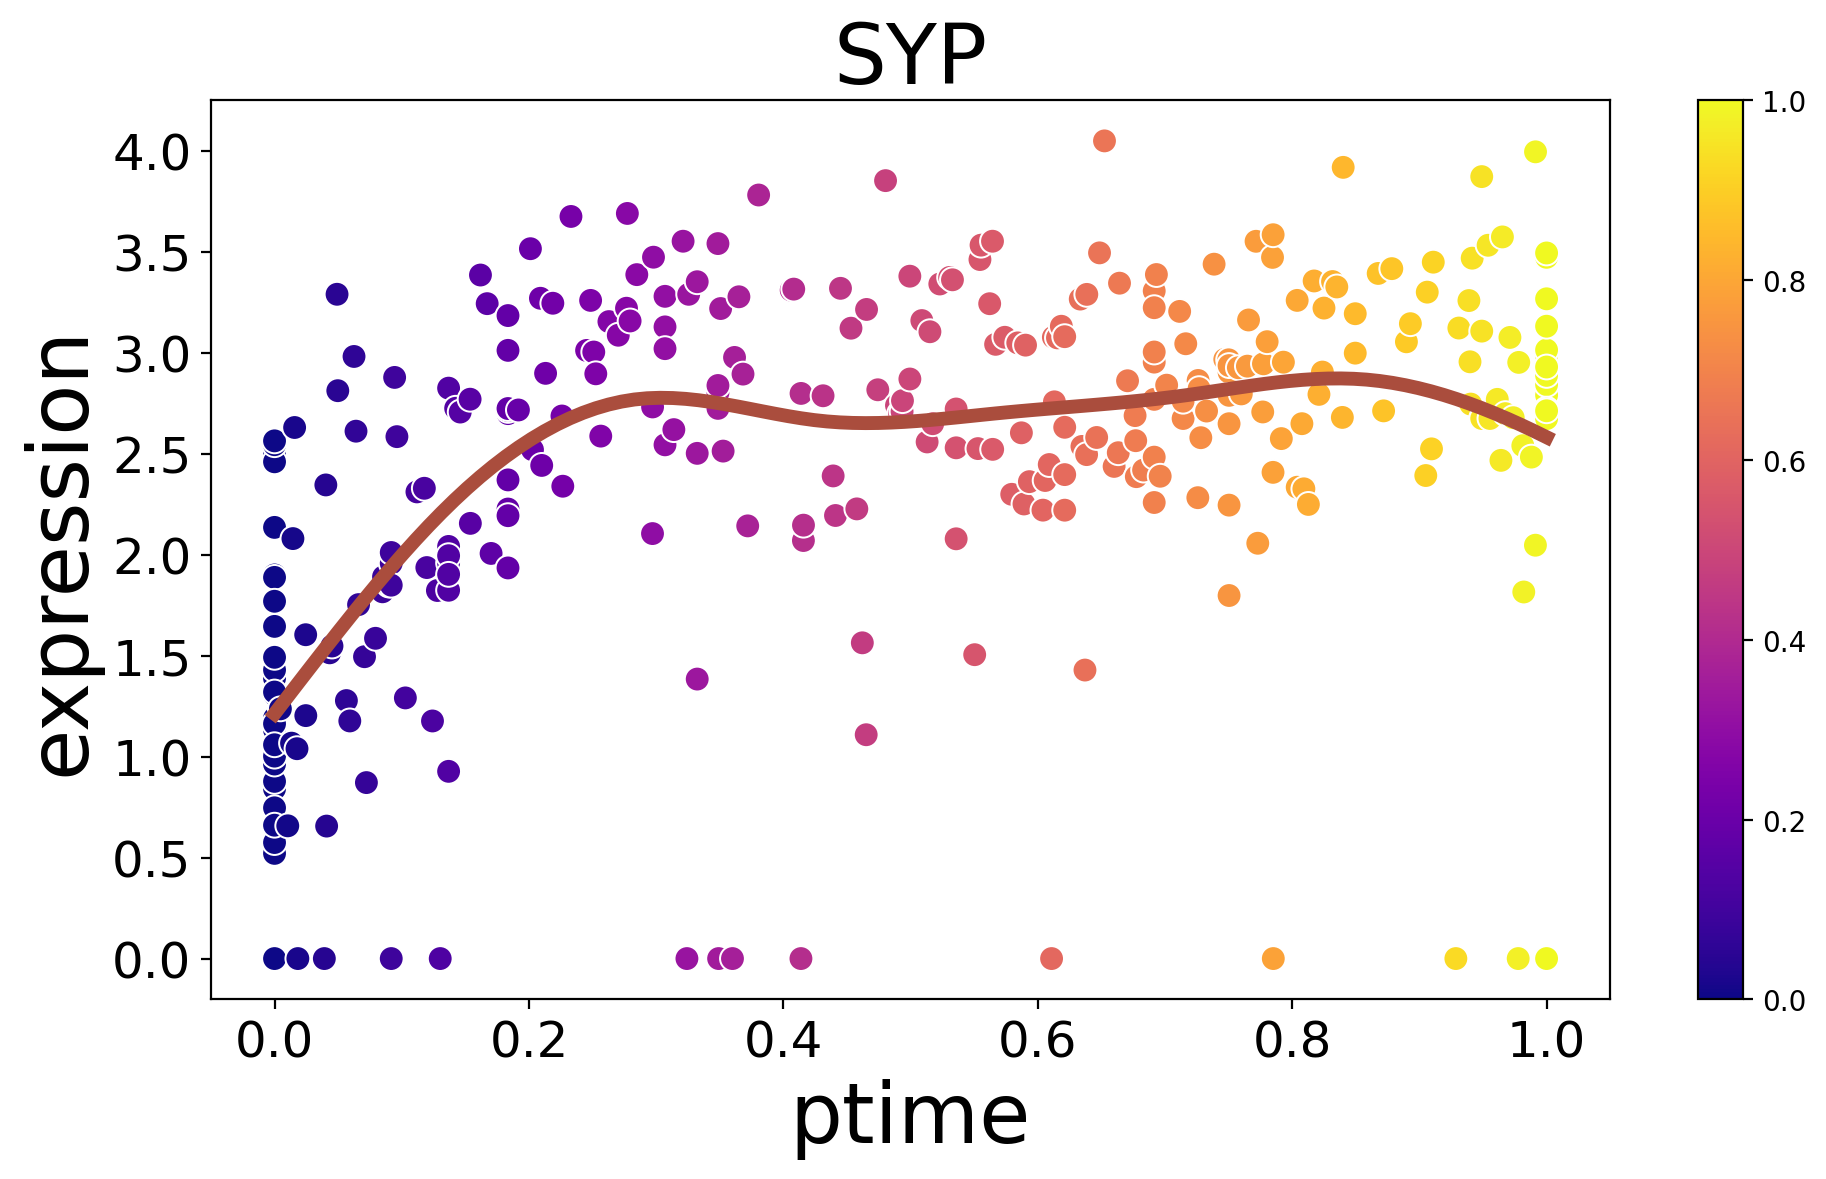

In [31]:
spt.plot_trajectory_gene(sub_adata,gene_name='SYP',point_size=80)